In [1]:
import os, sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

os.chdir(PROJECT_ROOT)
sys.path.insert(0, str(PROJECT_ROOT))



In [2]:
from research.feature_engineering.data_loader import load_data
from research.feature_engineering.preprocess import add_mid_price
from research.feature_engineering.features import add_features
from research.feature_engineering.labels import add_label
from xgboost import XGBClassifier

df = load_data("data/raw/bank-nifty-1m-data.csv")
df = add_mid_price(df)
df = add_features(df)
df = add_label(df)
df = df.dropna()

features = ['ret1','ret5','vol10','vol30','pressure','trend_ratio']
X = df[features]
y = (df['y'] > 0).astype(int)

model = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8
)
model.fit(X, y)

df['prob'] = model.predict_proba(X)[:,1]


In [3]:
LONG_TH = 0.6
SHORT_TH = 0.4

df['signal'] = 0
df.loc[df['prob'] > LONG_TH, 'signal'] = 1
df.loc[df['prob'] < SHORT_TH, 'signal'] = -1


In [4]:
max_leverage = 2.0
min_vol = 0.0005

rolling_vol = df['y'].rolling(50).std().clip(lower=min_vol)
raw_size = 0.01 / rolling_vol

df['position_size'] = raw_size.clip(0, max_leverage)




In [5]:
df['signal_raw'] = df['signal']

df['strategy_ret'] = df['signal_raw'].shift(1) * df['y'] * df['position_size']
df['equity'] = (1 + df['strategy_ret']).cumprod()



In [6]:
df['peak'] = df['equity'].cummax()
df['dd'] = df['equity'] / df['peak'] - 1

halt = df['dd'] < -0.25
df.loc[halt, 'signal_raw'] = 0

df['smooth_size'] = df['position_size'].rolling(10).mean().clip(0, 1.5)



In [7]:
cooldown = 500

df['cooldown_flag'] = 0
for i in range(1, len(df)):
    if df['dd'].iloc[i-1] < -0.15:
        df.loc[i:i+cooldown, 'cooldown_flag'] = 1

df.loc[df['cooldown_flag'] == 1, 'signal_raw'] = 0



In [8]:
df['strategy_ret'] = df['signal_raw'].shift(1) * df['y'] * df['smooth_size']
df['equity'] = (1 + df['strategy_ret']).cumprod()

Sharpe: 2.5856951343551056
Max Drawdown: -0.27078223110693966


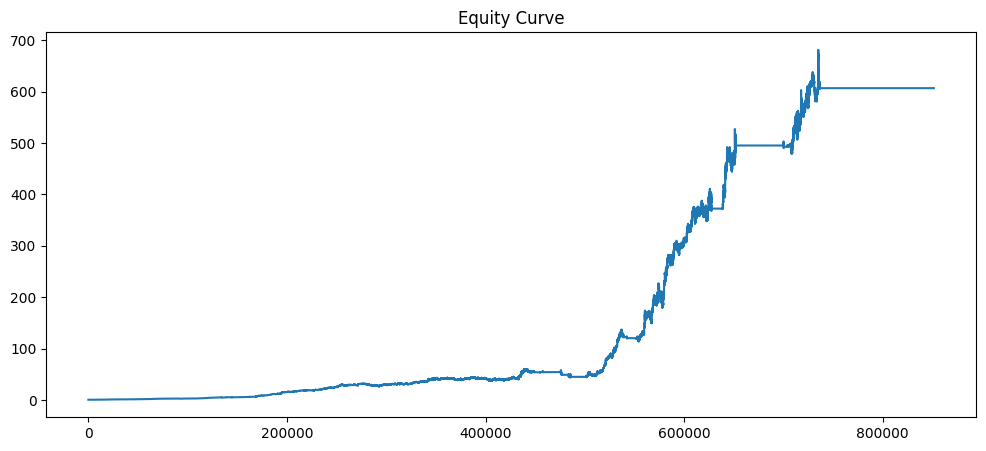

In [9]:
sharpe = np.sqrt(252*390) * df['strategy_ret'].mean() / df['strategy_ret'].std()
max_dd = (df['equity'] / df['equity'].cummax() - 1).min()

print("Sharpe:", sharpe)
print("Max Drawdown:", max_dd)

plt.figure(figsize=(12,5))
plt.plot(df['equity'])
plt.title("Equity Curve")
plt.show()
